# Predicting faulty water pumps


## Background

This series of notebook will focus on a  predictive maintenance problem competition. The business challenge is brought by www.drivendata.org and the goal is to  predict the operation state (functional, repair needed, complete failure) of water pumps in Tanzania. The water pump data is provided by taarifa.org an organization that provides people the ability to report water and sanitation problems in Africa. Here is a dashboard of the status of water points in Tanzania: http://dashboard.taarifa.org/#/dashboard.</br>

## Business Objectives
Using data from Taarifa and the Tanzanian Ministry of Water, we will be trying to predict which pumps are functional, which need some repairs, and which don't work at all. Prediction will be based on on a number of variables:  what kind of pump is operating, when it was installed, and how it is managed etc. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania</br>

Reference: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table

# Data Cleaning & Feature Engineering & Pre-processing¶

## Import Libraries
Import libraries necessary to get the exploratory data analysis (EDA) part of the project set-up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
%matplotlib inline

Define a custom function which will impute null or missing values based on the highest occurance of these values for a specific slice of another feature  

In [612]:
# impute missing values based on the hightest occurence of this value in a seperate data slice
def impute_null_with_highest_frequency_value(df, impute_feature, frequency_feature, verbose = False):
    impute_cat_set = df[impute_feature].nunique()
    feat_cat_list = df[frequency_feature].unique()
    
    for i in feat_cat_list:
        feat_cat = train_features_df[df[frequency_feature] == i][impute_feature]  
        highest_feat_cat_occurence = df[frequency_feature].value_counts().idxmax()
        if sum(feat_cat.notnull()):
            highest_feat_cat_occurence = feat_cat.value_counts().idxmax()        
        if verbose:
            print("Replacing {} feature null values: {} imputed by {}".format(impute_feature,i,highest_feat_cat_occurence))
        df[impute_feature].fillna(value=highest_feat_cat_occurence, inplace = True)
        
    # Sanity check for replaced null values
    assert impute_cat_set == df[impute_feature].nunique(), "impute_null_with_highest_frequency_value: null values replaced assert failed"

Define a list item removal utility function

In [613]:
# Remove a sublist from a list
def remove_list(orginal_list, list_to_be_removed):
    for i in list_to_be_removed:
        orginal_list.remove(i)

## Load Water Pump Data Frames

Read in the data pump files stored in the directory raw-data into Pandas dataframes

In [614]:
!dir raw-data\*.pkl

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\Udacity\machine-learning\projects\capstone-project\raw-data

05/31/2018  12:20 PM         3,634,926 pump_test_features_df.pkl
05/31/2018  12:20 PM        14,615,910 pump_train_features_df.pkl
05/31/2018  12:20 PM           594,995 pump_train_label_df.pkl
               3 File(s)     18,845,831 bytes
               0 Dir(s)  1,928,122,032,128 bytes free


In [615]:
train_features_df = pd.read_pickle('raw-data\pump_train_features_df.pkl')
train_label_df = pd.read_pickle('raw-data\pump_train_label_df.pkl')
test_features_df = pd.read_pickle('raw-data\pump_test_features_df.pkl')
print("Confirm shapes of the train and test dataframes:",train_features_df.shape, train_label_df.shape, test_features_df.shape)

('Confirm shapes of the train and test dataframes:', (59400, 40), (59400, 2), (14850, 40))


Merge training features (include the target labels) based on water pump id

In [616]:
train_features_df = pd.merge(left=train_features_df, right=train_label_df, how='inner', on='id')
train_features_df.shape

(59400, 41)

## Clean and Pre-process the data

### Standardise all string categorical values to lower case

In [617]:
ordinal_cols = ['region_code', 'district_code']
# Transform ordinal values as object values 
for col in ordinal_cols:
    train_features_df[col] = train_features_df[col].astype('str')

# We will exclude the boolean features in this section, these will be hot encoded at a later stage
bool_cols = ['public_meeting', 'permit']
other_cols_to_exclide = ['status_group', 'date_recorded']

# retrieve all other categorical variable
categorical_cols = train_features_df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = categorical_cols[1:] #exclude dates & target feature
remove_list(categorical_cols,bool_cols) #exclude boolean feature
print(categorical_cols)

['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [618]:
# Normalise string categorical features to lower case 
for i in categorical_cols:
    train_features_df[i] = train_features_df[i].str.lower()

### Inpute missing values
We've previously seen that the following features have NaN values that we will drop or impute: <br/> <br/>

<B> Nan/Null values count by feature: </B>

* scheme_name:              28166
* scheme_management:         3877
* installer:                 3655
* funder:                    3635
* public_meeting:            3334
* permit:                    3056
* subvillage:                 371

#### Address pump funder and installer missing values
* funder - Who funded the well 
* installer - Organization that installed the well

In [619]:
train_features_df['funder'].value_counts().head()

government of tanzania    9084
danida                    3114
hesawa                    2202
rwssp                     1374
world bank                1349
Name: funder, dtype: int64

In [620]:
train_features_df['installer'].value_counts().head()

dwe           17405
government     1891
hesawa         1395
rwe            1206
commu          1065
Name: installer, dtype: int64

In [621]:
# replace missing values from the funder feature with the highest occurence of funders
highest_funder_occurence = train_features_df['funder'].value_counts().idxmax()
train_features_df['funder'].fillna(value=highest_funder_occurence, inplace = True)
train_features_df['installer'].value_counts().head()

dwe           17405
government     1891
hesawa         1395
rwe            1206
commu          1065
Name: installer, dtype: int64

In [622]:
# Replace the missing values of the installer feature with with the highest occurence of installers for VWC management schemes 
highest_installer_occurence = train_features_df['funder'].value_counts().idxmax()
train_features_df['installer'].fillna(value=highest_installer_occurence, inplace = True)

In [623]:
# Check no null values left for funder and installer features
total_null_values = sum(train_features_df['funder'].isnull()) + sum(train_features_df['installer'].isnull())
assert total_null_values == 0, "Features: funder & installer - missing values replacement assert failed"

#### Address pump scheme_name & scheme_management missing values
* scheme_management - Who operates the waterpoint
* scheme_name - Who operates the waterpoint

In [624]:
# drop scheme_management feature: too many missing values
print(train_features_df['scheme_name'].unique())
train_features_df.drop('scheme_name', axis =1, inplace = True)
categorical_cols.remove('scheme_name')
print(categorical_cols)

['roman' nan 'nyumba ya mungu pipe scheme' ..., 'bl nsherehehe'
 'magati  gravity spri' 'mtawanya']
['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'recorded_by', 'scheme_management', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [625]:
# replace scheme_management feature missing values by highest occurence for each funder category
impute_null_with_highest_frequency_value(train_features_df, 'scheme_management', 'funder')

Replacing scheme_management feature null values: roman imputed by vwc
Replacing scheme_management feature null values: grumeti imputed by wug
Replacing scheme_management feature null values: lottery club imputed by vwc
Replacing scheme_management feature null values: unicef imputed by vwc
Replacing scheme_management feature null values: action in a imputed by vwc
Replacing scheme_management feature null values: mkinga distric coun imputed by vwc
Replacing scheme_management feature null values: dwsp imputed by wug
Replacing scheme_management feature null values: rwssp imputed by wug
Replacing scheme_management feature null values: wateraid imputed by vwc
Replacing scheme_management feature null values: isingiro ho imputed by vwc
Replacing scheme_management feature null values: private imputed by private operator
Replacing scheme_management feature null values: danida imputed by vwc
Replacing scheme_management feature null values: world vision imputed by vwc
Replacing scheme_management f

Replacing scheme_management feature null values: go imputed by vwc
Replacing scheme_management feature null values: cdtf imputed by vwc
Replacing scheme_management feature null values: shawasa imputed by vwc
Replacing scheme_management feature null values: un imputed by vwc
Replacing scheme_management feature null values: awf imputed by vwc
Replacing scheme_management feature null values: commu imputed by vwc
Replacing scheme_management feature null values: community imputed by vwc
Replacing scheme_management feature null values: save the rain usa imputed by wua
Replacing scheme_management feature null values: kibara foundation imputed by parastatal
Replacing scheme_management feature null values: tlc imputed by vwc
Replacing scheme_management feature null values: rc churc imputed by vwc
Replacing scheme_management feature null values: plan int imputed by vwc
Replacing scheme_management feature null values: w.b imputed by vwc
Replacing scheme_management feature null values: lvia impute

Replacing scheme_management feature null values: mbiuwasa imputed by water board
Replacing scheme_management feature null values: the isla imputed by vwc
Replacing scheme_management feature null values: rotary club imputed by wua
Replacing scheme_management feature null values: muslims imputed by water authority
Replacing scheme_management feature null values: care international imputed by wug
Replacing scheme_management feature null values: kimkuma imputed by vwc
Replacing scheme_management feature null values: tanesco imputed by private operator
Replacing scheme_management feature null values: mbozi district council imputed by vwc
Replacing scheme_management feature null values: dasip imputed by vwc
Replacing scheme_management feature null values: tltc imputed by vwc
Replacing scheme_management feature null values: sdg imputed by wug
Replacing scheme_management feature null values: hsw imputed by vwc
Replacing scheme_management feature null values: mwaya mn imputed by wua
Replacing s

Replacing scheme_management feature null values: qwiqwi imputed by vwc
Replacing scheme_management feature null values: pmo imputed by wug
Replacing scheme_management feature null values: tuwasa imputed by other
Replacing scheme_management feature null values: irish ai imputed by vwc
Replacing scheme_management feature null values: mdrdp imputed by vwc
Replacing scheme_management feature null values: jeshi la wokovu imputed by vwc
Replacing scheme_management feature null values: government /tassaf imputed by vwc
Replacing scheme_management feature null values: mboma imputed by vwc
Replacing scheme_management feature null values: people from japan imputed by vwc
Replacing scheme_management feature null values: kilindi district co imputed by vwc
Replacing scheme_management feature null values: shamte said imputed by private operator
Replacing scheme_management feature null values: auwasa imputed by water authority
Replacing scheme_management feature null values: kidp imputed by water aut

Replacing scheme_management feature null values: danida /government imputed by vwc
Replacing scheme_management feature null values: semaki k imputed by vwc
Replacing scheme_management feature null values: arabs community imputed by vwc
Replacing scheme_management feature null values: water aid/sema imputed by vwc
Replacing scheme_management feature null values: district rural project imputed by parastatal
Replacing scheme_management feature null values: gen imputed by vwc
Replacing scheme_management feature null values: redep imputed by vwc
Replacing scheme_management feature null values: kiwanda cha samaki imputed by vwc
Replacing scheme_management feature null values: singida yetu imputed by wug
Replacing scheme_management feature null values: rwsp imputed by wug
Replacing scheme_management feature null values: moravian imputed by vwc
Replacing scheme_management feature null values: sema s imputed by wug
Replacing scheme_management feature null values: cbhi imputed by vwc
Replacing s

Replacing scheme_management feature null values: wahidi imputed by private operator
Replacing scheme_management feature null values: asdp imputed by vwc
Replacing scheme_management feature null values: kadp imputed by water authority
Replacing scheme_management feature null values: aco/germany imputed by vwc
Replacing scheme_management feature null values: majengo prima imputed by parastatal
Replacing scheme_management feature null values: hortanzia imputed by vwc
Replacing scheme_management feature null values: quick imputed by vwc
Replacing scheme_management feature null values: hasnan murig (mbunge) imputed by vwc
Replacing scheme_management feature null values: ikeuchi towels japan imputed by parastatal
Replacing scheme_management feature null values: halmashauli imputed by vwc
Replacing scheme_management feature null values: acord imputed by wua
Replacing scheme_management feature null values: menon imputed by vwc
Replacing scheme_management feature null values: wate aid/sema impu

Replacing scheme_management feature null values: dadp imputed by vwc
Replacing scheme_management feature null values: ikela wa imputed by company
Replacing scheme_management feature null values: rotary i imputed by vwc
Replacing scheme_management feature null values: rwssp/wsdp imputed by water authority
Replacing scheme_management feature null values: christian outrich imputed by private operator
Replacing scheme_management feature null values: cipro/care/tcrs imputed by water authority
Replacing scheme_management feature null values: italian imputed by parastatal
Replacing scheme_management feature null values: kome parish imputed by vwc
Replacing scheme_management feature null values: mwanga town water authority imputed by water authority
Replacing scheme_management feature null values: jumanne siabo imputed by vwc
Replacing scheme_management feature null values: hindu imputed by vwc
Replacing scheme_management feature null values: rural imputed by vwc
Replacing scheme_management fe

Replacing scheme_management feature null values: mp imputed by vwc
Replacing scheme_management feature null values: islam imputed by vwc
Replacing scheme_management feature null values: dassip imputed by wug
Replacing scheme_management feature null values: rvemp imputed by wug
Replacing scheme_management feature null values: adp bungu imputed by vwc
Replacing scheme_management feature null values: thomasi busigaye imputed by private operator
Replacing scheme_management feature null values: sijm imputed by water authority
Replacing scheme_management feature null values: w.d & i. imputed by vwc
Replacing scheme_management feature null values: british tanza imputed by vwc
Replacing scheme_management feature null values: kkkt ndrumangeni imputed by wua
Replacing scheme_management feature null values: tag church imputed by water authority
Replacing scheme_management feature null values: council imputed by vwc
Replacing scheme_management feature null values: usambala sister imputed by vwc
Re

Replacing scheme_management feature null values: busoga trust imputed by vwc
Replacing scheme_management feature null values: mzee mabena imputed by wua
Replacing scheme_management feature null values: br imputed by vwc
Replacing scheme_management feature null values: brad imputed by wua
Replacing scheme_management feature null values: koico imputed by vwc
Replacing scheme_management feature null values: healt imputed by vwc
Replacing scheme_management feature null values: ro imputed by vwc
Replacing scheme_management feature null values: jeshi lawokovu imputed by vwc
Replacing scheme_management feature null values: paffect mwanaindi imputed by vwc
Replacing scheme_management feature null values: tansi imputed by other
Replacing scheme_management feature null values: craelius imputed by vwc
Replacing scheme_management feature null values: apm[africa precious metals lt imputed by vwc
Replacing scheme_management feature null values: zao water spring x imputed by vwc
Replacing scheme_mana

Replacing scheme_management feature null values: japan embassy imputed by vwc
Replacing scheme_management feature null values: jacobin imputed by vwc
Replacing scheme_management feature null values: greinaker imputed by vwc
Replacing scheme_management feature null values: totoland imputed by other
Replacing scheme_management feature null values: bahresa imputed by vwc
Replacing scheme_management feature null values: mwalimu muhenza imputed by private operator
Replacing scheme_management feature null values: handeni trunk main( imputed by vwc
Replacing scheme_management feature null values: cefa/rcchurch imputed by wua
Replacing scheme_management feature null values: quick win imputed by vwc
Replacing scheme_management feature null values: prince medium school imputed by company
Replacing scheme_management feature null values: mtibwa s imputed by vwc
Replacing scheme_management feature null values: stansilaus imputed by wug
Replacing scheme_management feature null values: sakwidi impute

Replacing scheme_management feature null values: ruped imputed by vwc
Replacing scheme_management feature null values: tgz imputed by company
Replacing scheme_management feature null values: g.d&i.d imputed by vwc
Replacing scheme_management feature null values: act imputed by vwc
Replacing scheme_management feature null values: samweli mshosha imputed by private operator
Replacing scheme_management feature null values: lga and adb imputed by vwc
Replacing scheme_management feature null values: ifakara imputed by vwc
Replacing scheme_management feature null values: village contributio imputed by vwc
Replacing scheme_management feature null values: rotery c imputed by vwc
Replacing scheme_management feature null values: rodri imputed by private operator
Replacing scheme_management feature null values: dar es salaam round table imputed by vwc
Replacing scheme_management feature null values: bkhws imputed by parastatal
Replacing scheme_management feature null values: njula imputed by vwc


Replacing scheme_management feature null values: colonial government imputed by vwc
Replacing scheme_management feature null values: angrikana imputed by vwc
Replacing scheme_management feature null values: bhws imputed by parastatal
Replacing scheme_management feature null values: mazaro kabula imputed by vwc
Replacing scheme_management feature null values: domestic rural development pr imputed by vwc
Replacing scheme_management feature null values: zingibali secondary imputed by vwc
Replacing scheme_management feature null values: bio fuel company imputed by vwc
Replacing scheme_management feature null values: runda imputed by vwc
Replacing scheme_management feature null values: morad imputed by vwc
Replacing scheme_management feature null values: pentecostal church imputed by water authority
Replacing scheme_management feature null values: tajiri jumbe lila imputed by private operator
Replacing scheme_management feature null values: ngelepo group imputed by trust
Replacing scheme_ma

Replacing scheme_management feature null values: idf imputed by wug
Replacing scheme_management feature null values: trach imputed by vwc
Replacing scheme_management feature null values: wdp imputed by wug
Replacing scheme_management feature null values: uvimaki imputed by vwc
Replacing scheme_management feature null values: eung am methodist church imputed by vwc
Replacing scheme_management feature null values: sdp imputed by vwc
Replacing scheme_management feature null values: kitiangare village community imputed by vwc
Replacing scheme_management feature null values: luchelegu primary school imputed by parastatal
Replacing scheme_management feature null values: raramataki imputed by water authority
Replacing scheme_management feature null values: rc/dwe imputed by vwc
Replacing scheme_management feature null values: ministry of agricultura imputed by vwc
Replacing scheme_management feature null values: mtewe imputed by vwc
Replacing scheme_management feature null values: unicef/afri

Replacing scheme_management feature null values: sda church imputed by water authority
Replacing scheme_management feature null values: missio imputed by vwc
Replacing scheme_management feature null values: kigwa imputed by vwc
Replacing scheme_management feature null values: arabi imputed by vwc
Replacing scheme_management feature null values: c imputed by vwc
Replacing scheme_management feature null values: luali kaima imputed by private operator
Replacing scheme_management feature null values: vicfish imputed by vwc
Replacing scheme_management feature null values: methodist church imputed by parastatal
Replacing scheme_management feature null values: s.s mohamed imputed by vwc
Replacing scheme_management feature null values: selestine mganga imputed by vwc
Replacing scheme_management feature null values: mashaka imputed by private operator
Replacing scheme_management feature null values: doner and com imputed by vwc
Replacing scheme_management feature null values: jwtz imputed by ot

Replacing scheme_management feature null values: education funds imputed by vwc
Replacing scheme_management feature null values: rhobi wambura imputed by other
Replacing scheme_management feature null values: tabea imputed by vwc
Replacing scheme_management feature null values: suasa imputed by company
Replacing scheme_management feature null values: un habitat imputed by private operator
Replacing scheme_management feature null values: stephano paulo imputed by other
Replacing scheme_management feature null values: kegocha imputed by other
Replacing scheme_management feature null values: mfuko wa jimbo la magu imputed by vwc
Replacing scheme_management feature null values: egypt government imputed by vwc
Replacing scheme_management feature null values: mzee ngwatu imputed by vwc
Replacing scheme_management feature null values: perusi bhoke imputed by other
Replacing scheme_management feature null values: makondakonde water population imputed by vwc
Replacing scheme_management feature 

Replacing scheme_management feature null values: mganga imputed by vwc
Replacing scheme_management feature null values: carmatech imputed by vwc
Replacing scheme_management feature null values: buluga subvillage community imputed by vwc
Replacing scheme_management feature null values: lake tanganyika prodap imputed by vwc
Replacing scheme_management feature null values: kdpa imputed by parastatal
Replacing scheme_management feature null values: nyamingu subvillage imputed by vwc
Replacing scheme_management feature null values: ballo imputed by vwc
Replacing scheme_management feature null values: fiwater imputed by water board
Replacing scheme_management feature null values: mwelia estate imputed by vwc
Replacing scheme_management feature null values: sister makulata imputed by private operator
Replacing scheme_management feature null values: veo imputed by company
Replacing scheme_management feature null values: qwick win imputed by wug
Replacing scheme_management feature null values: 

Replacing scheme_management feature null values: quicklw imputed by vwc
Replacing scheme_management feature null values: daida imputed by parastatal
Replacing scheme_management feature null values: college imputed by vwc
Replacing scheme_management feature null values: cdtfdistrict council imputed by vwc
Replacing scheme_management feature null values: batist church imputed by wug
Replacing scheme_management feature null values: kurrp imputed by vwc
Replacing scheme_management feature null values: hesawza imputed by vwc
Replacing scheme_management feature null values: water aid/dwe imputed by vwc
Replacing scheme_management feature null values: rudri imputed by vwc
Replacing scheme_management feature null values: bgssws imputed by other
Replacing scheme_management feature null values: ch imputed by vwc
Replacing scheme_management feature null values: haruna mpog imputed by private operator
Replacing scheme_management feature null values: swiss tr imputed by vwc
Replacing scheme_managem

Replacing scheme_management feature null values: dgv imputed by vwc
Replacing scheme_management feature null values: upendo primary school imputed by wua
Replacing scheme_management feature null values: sipdo imputed by vwc
Replacing scheme_management feature null values: hongoli imputed by vwc
Replacing scheme_management feature null values: resolute mininggolden pride imputed by vwc
Replacing scheme_management feature null values: norad/government imputed by water authority
Replacing scheme_management feature null values: tove imputed by vwc
Replacing scheme_management feature null values: nerthlands imputed by vwc
Replacing scheme_management feature null values: nazalet church imputed by vwc
Replacing scheme_management feature null values: scharnhorstgymnasium imputed by parastatal
Replacing scheme_management feature null values: wanginyi water imputed by vwc
Replacing scheme_management feature null values: cida imputed by vwc
Replacing scheme_management feature null values: dwe/ang

In [626]:
# Check no null values left for funder and installer features
total_null_values = sum(train_features_df['scheme_management'].isnull())
assert total_null_values == 0, "Features: scheme_management - missing values replacement assert failed"

#### Address public_meeting and permit features missing values
* public_meeting - True/False
* permit - If the waterpoint is permitted

In [627]:
# replace public_meeting feature missing values by highest occurence - it is clearly True
train_features_df['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [628]:
train_features_df['public_meeting'].fillna(value=True, inplace = True) 
assert total_null_values == 0, "Features: public_meeting - missing values replacement assert failed"

In [629]:
# replace permit feature missing values is more tricky since it is distributed 1/3 for False and 2/3 for True
train_features_df['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [630]:
# replace scheme_management feature missing values by highest occurence for each installer category
impute_null_with_highest_frequency_value(train_features_df, 'permit', 'installer')

Replacing permit feature null values: roman imputed by False
Replacing permit feature null values: grumeti imputed by False
Replacing permit feature null values: world vision imputed by True
Replacing permit feature null values: unicef imputed by False
Replacing permit feature null values: artisan imputed by True
Replacing permit feature null values: dwe imputed by True
Replacing permit feature null values: dwsp imputed by True
Replacing permit feature null values: water aid imputed by True
Replacing permit feature null values: private imputed by False
Replacing permit feature null values: danida imputed by True
Replacing permit feature null values: lawatefuka water sup imputed by True
Replacing permit feature null values: wedeco imputed by True
Replacing permit feature null values: danid imputed by True
Replacing permit feature null values: twe imputed by False
Replacing permit feature null values: isf imputed by True
Replacing permit feature null values: kilolo star imputed by False


Replacing permit feature null values: gover imputed by True
Replacing permit feature null values: mission imputed by True
Replacing permit feature null values: dwe/ imputed by False
Replacing permit feature null values: halmashauri ya wilaya sikonge imputed by True
Replacing permit feature null values: ki imputed by True
Replacing permit feature null values: rhoda imputed by False
Replacing permit feature null values: hapa singida imputed by True
Replacing permit feature null values: consulting engineer imputed by False
Replacing permit feature null values: karugendo imputed by False
Replacing permit feature null values: co imputed by True
Replacing permit feature null values: marafip imputed by True
Replacing permit feature null values: cosmos eng ltd imputed by True
Replacing permit feature null values: world banks imputed by True
Replacing permit feature null values: tanz imputed by False
Replacing permit feature null values: handeni trunk main( imputed by True
Replacing permit feat

Replacing permit feature null values: kirdep imputed by True
Replacing permit feature null values: adra/government imputed by True
Replacing permit feature null values: kilwater imputed by True
Replacing permit feature null values: villi imputed by False
Replacing permit feature null values: koyi imputed by True
Replacing permit feature null values: ad imputed by True
Replacing permit feature null values: arab community imputed by False
Replacing permit feature null values: district water depar imputed by True
Replacing permit feature null values: holland imputed by False
Replacing permit feature null values: rc church/central gover imputed by True
Replacing permit feature null values: active mkm imputed by False
Replacing permit feature null values: geotan imputed by True
Replacing permit feature null values: lench imputed by True
Replacing permit feature null values: ncaa imputed by True
Replacing permit feature null values: china henan constuction imputed by True
Replacing permit fe

Replacing permit feature null values: kalago enterprises co.ltd imputed by False
Replacing permit feature null values: roman catholic imputed by True
Replacing permit feature null values: nanra contractor imputed by False
Replacing permit feature null values: no imputed by True
Replacing permit feature null values: adp busangi imputed by True
Replacing permit feature null values: tsrc imputed by True
Replacing permit feature null values: solidame imputed by True
Replacing permit feature null values: barry a. murphy imputed by False
Replacing permit feature null values: tanzania government imputed by False
Replacing permit feature null values: williamson diamond ltd imputed by True
Replacing permit feature null values: tag imputed by True
Replacing permit feature null values: the i imputed by True
Replacing permit feature null values: arabs community imputed by True
Replacing permit feature null values: water aid/sema imputed by True
Replacing permit feature null values: jiks imputed by

Replacing permit feature null values: halmashauri ya wilaya imputed by False
Replacing permit feature null values: edward imputed by True
Replacing permit feature null values: baric imputed by True
Replacing permit feature null values: consuting engineer imputed by False
Replacing permit feature null values: jandu plumber co imputed by True
Replacing permit feature null values: cpro imputed by True
Replacing permit feature null values: getekwe imputed by False
Replacing permit feature null values: jicks imputed by True
Replacing permit feature null values: wahidi imputed by False
Replacing permit feature null values: mohamed ally imputed by True
Replacing permit feature null values: asdp imputed by False
Replacing permit feature null values: citizen engine imputed by True
Replacing permit feature null values: kadp imputed by True
Replacing permit feature null values: dar es salaam technician imputed by False
Replacing permit feature null values: halmashauli imputed by True
Replacing pe

Replacing permit feature null values: sanje wa imputed by True
Replacing permit feature null values: makundya imputed by True
Replacing permit feature null values: individual imputed by True
Replacing permit feature null values: ola imputed by False
Replacing permit feature null values: rc c imputed by True
Replacing permit feature null values: tredep imputed by True
Replacing permit feature null values: consultant engineer imputed by False
Replacing permit feature null values: aqua wel imputed by True
Replacing permit feature null values: cental government imputed by True
Replacing permit feature null values: nyanza road imputed by True
Replacing permit feature null values: kizenga imputed by False
Replacing permit feature null values: kkt imputed by True
Replacing permit feature null values: hapa imputed by True
Replacing permit feature null values: oikos e. africa imputed by True
Replacing permit feature null values: ramadhani nyambizi imputed by False
Replacing permit feature null 

Replacing permit feature null values: kashwa imputed by True
Replacing permit feature null values: twende pamoja imputed by True
Replacing permit feature null values: uhai wa mama na mtoto imputed by False
Replacing permit feature null values: olomoloki imputed by True
Replacing permit feature null values: ardhi water well imputed by False
Replacing permit feature null values: distric water department imputed by False
Replacing permit feature null values: gwitembe imputed by False
Replacing permit feature null values: conta imputed by False
Replacing permit feature null values: howard humfreys imputed by False
Replacing permit feature null values: shuwasa imputed by True
Replacing permit feature null values: jandu plumber  co imputed by False
Replacing permit feature null values: makori imputed by True
Replacing permit feature null values: sangea district coun imputed by True
Replacing permit feature null values: british colonial government imputed by True
Replacing permit feature null

Replacing permit feature null values: german imputed by False
Replacing permit feature null values: nssf imputed by False
Replacing permit feature null values: kilol imputed by True
Replacing permit feature null values: judge mchome imputed by True
Replacing permit feature null values: milenia imputed by True
Replacing permit feature null values: amp contracts imputed by False
Replacing permit feature null values: masjid imputed by False
Replacing permit feature null values: government /sda imputed by True
Replacing permit feature null values: farm-africa imputed by True
Replacing permit feature null values: mama agnes kagimbo imputed by False
Replacing permit feature null values: universal construction imputed by True
Replacing permit feature null values: bffs imputed by False
Replacing permit feature null values: kyela_morogoro imputed by True
Replacing permit feature null values: msikitini imputed by False
Replacing permit feature null values: hdv imputed by True
Replacing permit fe

Replacing permit feature null values: american imputed by True
Replacing permit feature null values: anglican church imputed by True
Replacing permit feature null values: benguka imputed by False
Replacing permit feature null values: william acles imputed by True
Replacing permit feature null values: jackson makore imputed by True
Replacing permit feature null values: mr kwi imputed by True
Replacing permit feature null values: hanja lt imputed by True
Replacing permit feature null values: abdul imputed by False
Replacing permit feature null values: mwanamisi ally imputed by False
Replacing permit feature null values: kawinga imputed by True
Replacing permit feature null values: oda imputed by True
Replacing permit feature null values: action aid imputed by True
Replacing permit feature null values: w.c.s imputed by True
Replacing permit feature null values: okong'o imputed by False
Replacing permit feature null values: water department imputed by True
Replacing permit feature null val

Replacing permit feature null values: water hu imputed by True
Replacing permit feature null values: kk imputed by True
Replacing permit feature null values: cip imputed by True
Replacing permit feature null values: monmali imputed by True
Replacing permit feature null values: dw$ imputed by True
Replacing permit feature null values: karumba biulding contractor imputed by False
Replacing permit feature null values: dspu imputed by False
Replacing permit feature null values: nu imputed by True
Replacing permit feature null values: ccp imputed by False
Replacing permit feature null values: upendo group imputed by True
Replacing permit feature null values: grumeti singita imputed by False
Replacing permit feature null values: insititutiona imputed by True
Replacing permit feature null values: colonial government imputed by False
Replacing permit feature null values: tukware enterp imputed by True
Replacing permit feature null values: angrikana imputed by True
Replacing permit feature null

Replacing permit feature null values: mwita machoa imputed by True
Replacing permit feature null values: wdp imputed by False
Replacing permit feature null values: gra imputed by False
Replacing permit feature null values: sdp imputed by False
Replacing permit feature null values: pentecostal church imputed by True
Replacing permit feature null values: kisiriri adp imputed by True
Replacing permit feature null values: kitiangare village community imputed by True
Replacing permit feature null values: raramataki imputed by False
Replacing permit feature null values: bridge north imputed by True
Replacing permit feature null values: mtewe imputed by False
Replacing permit feature null values: dfid imputed by True
Replacing permit feature null values: elius chacha imputed by False
Replacing permit feature null values: ox imputed by True
Replacing permit feature null values: water /sema imputed by True
Replacing permit feature null values: presadom imputed by True
Replacing permit feature n

Replacing permit feature null values: motiba manyanya imputed by True
Replacing permit feature null values: meco imputed by True
Replacing permit feature null values: neemia mission imputed by True
Replacing permit feature null values: rashid seng'ombe imputed by False
Replacing permit feature null values: msagin imputed by True
Replacing permit feature null values: vodacom imputed by True
Replacing permit feature null values: altai co. ltd imputed by True
Replacing permit feature null values: chuo imputed by True
Replacing permit feature null values: zinduka imputed by False
Replacing permit feature null values: muslimehefen international imputed by False
Replacing permit feature null values: floresta imputed by False
Replacing permit feature null values: seronera imputed by True
Replacing permit feature null values: roman cathoric -same imputed by False
Replacing permit feature null values: richard m.kyore imputed by True
Replacing permit feature null values: maseka community imputed

Replacing permit feature null values: rotary club of chico and moshi imputed by True
Replacing permit feature null values: kyasha entrepr imputed by True
Replacing permit feature null values: indiv imputed by True
Replacing permit feature null values: juine co imputed by False
Replacing permit feature null values: malec imputed by True
Replacing permit feature null values: kagunguli secondary imputed by True
Replacing permit feature null values: boazi imputed by False
Replacing permit feature null values: aqal imputed by True
Replacing permit feature null values: males imputed by True
Replacing permit feature null values: c imputed by True
Replacing permit feature null values: tbl imputed by True
Replacing permit feature null values: tcrs/dwe imputed by True
Replacing permit feature null values: kando imputed by True
Replacing permit feature null values: egypt technical co operation imputed by False
Replacing permit feature null values: mbwambo imputed by False
Replacing permit feature

Replacing permit feature null values: anglikan imputed by True
Replacing permit feature null values: village water committee imputed by False
Replacing permit feature null values: tlc/sorri imputed by True
Replacing permit feature null values: africaone ltd imputed by False
Replacing permit feature null values: balyeh imputed by True
Replacing permit feature null values: emanda builders imputed by False
Replacing permit feature null values: unknown installer imputed by True
Replacing permit feature null values: sadiki kangelo imputed by False
Replacing permit feature null values: msukwa construction company imputed by False
Replacing permit feature null values: mwakifuna imputed by True
Replacing permit feature null values: marafin imputed by False
Replacing permit feature null values: emmanuel kitaponda imputed by True
Replacing permit feature null values: mbeje imputed by True
Replacing permit feature null values: wizra ya maji na egypt imputed by True
Replacing permit feature null v

Replacing permit feature null values: tz as imputed by False
Replacing permit feature null values: luka imputed by False
Replacing permit feature null values: jumuiya imputed by True
Replacing permit feature null values: arisan imputed by True
Replacing permit feature null values: makanya sisal estate imputed by True
Replacing permit feature null values: rural drinkung water supply imputed by True
Replacing permit feature null values: wwf/ imputed by True
Replacing permit feature null values: john skwese imputed by True
Replacing permit feature null values: peter imputed by True
Replacing permit feature null values: churc imputed by True
Replacing permit feature null values: enyuati imputed by True
Replacing permit feature null values: mr luo imputed by True
Replacing permit feature null values: noshad imputed by False
Replacing permit feature null values: ndrdp imputed by False
Replacing permit feature null values: ongan imputed by False
Replacing permit feature null values: nyabibuye

In [631]:
# Check no null values left for the permit feature
total_null_values = sum(train_features_df['permit'].isnull())
assert total_null_values == 0, "Features: permit- missing values replacement assert failed"

#### Address subvillage feature missing values
* subvillage - Geographic location

Inspect null values for the subvillage feature

In [632]:
train_features_df[train_features_df['subvillage'].isnull()]['region'].value_counts()

dodoma    361
mwanza     10
Name: region, dtype: int64

We observe that the null values for subvillage are located in two specific Tanzania regions: dodoma, mwanza

In [633]:
# replace subvillage feature missing values by highest occurence for each region category
impute_null_with_highest_frequency_value(train_features_df, 'subvillage', 'region')

Replacing subvillage feature null values: iringa imputed by m
Replacing subvillage feature null values: mara imputed by senta
Replacing subvillage feature null values: manyara imputed by madukani
Replacing subvillage feature null values: mtwara imputed by majengo
Replacing subvillage feature null values: kagera imputed by bunukangoma
Replacing subvillage feature null values: tanga imputed by sokoni
Replacing subvillage feature null values: shinyanga imputed by madukani
Replacing subvillage feature null values: tabora imputed by majengo
Replacing subvillage feature null values: pwani imputed by vikuge
Replacing subvillage feature null values: ruvuma imputed by muungano
Replacing subvillage feature null values: kilimanjaro imputed by majengo
Replacing subvillage feature null values: rukwa imputed by majengo
Replacing subvillage feature null values: mwanza imputed by 1
Replacing subvillage feature null values: kigoma imputed by majengo
Replacing subvillage feature null values: lindi imput

In [634]:
# Check no null values left for subvillage features
total_null_values = sum(train_features_df['subvillage'].isnull())
assert total_null_values == 0, "Features: subvillage - missing values replacement assert failed"

### Validate that all missing values have been imputed or dropped 

In [635]:
# Check if the training set has any missing values
num_null_val = train_features_df.isnull().sum().sort_values(ascending=False).head(10)
assert (sum(num_null_val) == 0), "Features: dataframe has missing values"

In [636]:
print(num_null_val)

status_group             0
waterpoint_type_group    0
population               0
ward                     0
lga                      0
district_code            0
region_code              0
region                   0
subvillage               0
basin                    0
dtype: int64


In [637]:
train_features_df.shape

(59400, 40)

## Engineer Features

#### Compute the age of the pumps based on the construction_year
The age of the pump will likely be a better predictor of a pump failure than the year it was constructed. <br/>
We will compute the age of the pumps at the time the data set observations were recorded

In [638]:
# Inspect construction_year feature
train_features_df['construction_year'].head()

0    1999
1    2010
2    2009
3    1986
4       0
Name: construction_year, dtype: int64

In [639]:
print("Construction year: min, max:",train_features_df['construction_year'].min(), train_features_df['construction_year'].max())
print("Number of invalid construction year values:", sum(train_features_df['construction_year'] == 0))

('Construction year: min, max:', 0, 2013)
('Number of invalid construction year values:', 20709)


More than 20000 pumps or 1/3 of our training data have invalid construction_year values (i.e. 0) and these values need to be imputed 

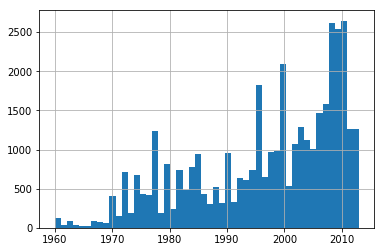

In [640]:
# Inspect the distribution of valid construction years (ie. not 0)
valid_construction_year_df = train_features_df[train_features_df['construction_year'] > 0]
valid_construction_year_df['construction_year'].hist(bins = 50)

In [641]:
# Compute the median contruction_year for pumps
median_construction_year_value=int(valid_construction_year_df['construction_year'].median())
median_construction_year_value

2000

In [642]:
# replace the 0 values in the construction_year by the median year
train_features_df['construction_year'].replace(0, median_construction_year_value,inplace=True)
print("Construction year: min, max:",train_features_df['construction_year'].min(), train_features_df['construction_year'].max())

('Construction year: min, max:', 1960, 2013)


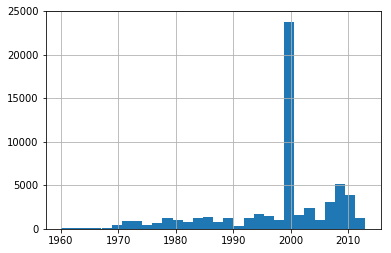

In [643]:
train_features_df['construction_year'].hist(bins = 30)

In [644]:
# Inspect date_recorded feature
train_features_df['date_recorded'].head()

0    2011-03-14
1    2013-03-06
2    2013-02-25
3    2013-01-28
4    2011-07-13
Name: date_recorded, dtype: object

In [645]:
# Extract the of date_recorded feature and create a new feature: year_recorded
def extract_year(date):
    return (int(date.split('-')[0]))

train_features_df['year_recorded'] = train_features_df['date_recorded'].apply(extract_year)
train_features_df['year_recorded'].head()

0    2011
1    2013
2    2013
3    2013
4    2011
Name: year_recorded, dtype: int64

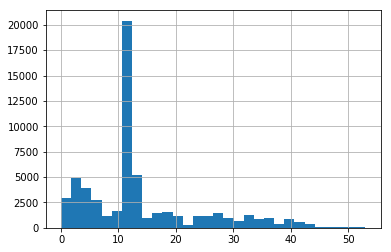

In [646]:
# Compute the age of each pump, we will drop the construction_year and date_recorded features later
train_features_df['pump_age'] = abs(train_features_df['construction_year'] - train_features_df['year_recorded'])
train_features_df['pump_age'].hist(bins = 30)

#### Transform the GPS location features

Tanzania is divided in water basin areas and this is likely relevant information for the prediction of the pump status 

In [647]:
basin_list = train_features_df['basin'].unique()
train_features_df['basin'].value_counts()

lake victoria              10248
pangani                     8940
rufiji                      7976
internal                    7785
lake tanganyika             6432
wami / ruvu                 5987
lake nyasa                  5085
ruvuma / southern coast     4493
lake rukwa                  2454
Name: basin, dtype: int64

![Tanzania Water Basin](https://www.researchgate.net/publication/312373453/figure/fig1/AS:471438105812994@1489411011502/Map-of-the-nine-River-Basin-Offices-in-Tanzania.png)

In [648]:
print(basin_list)

['lake nyasa' 'lake victoria' 'pangani' 'ruvuma / southern coast'
 'internal' 'lake tanganyika' 'wami / ruvu' 'rufiji' 'lake rukwa']


The GPS information of each pump is available in the following data set features:
* gps_height - Altitude of the well
* longitude - GPS coordinate 
* latitude - GPS coordinate 

In [649]:
# Inspect the GPS features and stats profile
gps_feature_list = ['gps_height', 'longitude', 'latitude']
train_features_df[gps_feature_list].describe()

,gps_height,longitude,latitude
count,59400.000000,59400.000000,5.940000e+04
mean,668.297239,34.077427,-5.706033e+00
std,693.116350,6.567432,2.946019e+00
min,-90.000000,0.000000,-1.164944e+01
25%,0.000000,33.090347,-8.540621e+00
50%,369.000000,34.908743,-5.021597e+00
75%,1319.250000,37.178387,-3.326156e+00
max,2770.000000,40.345193,-2.000000e-08


We notice that some of these GPS value are invalid (e.g. negative altitude) as Tanzania has the following GPS bounderies:
* height > 0
* latitude: between 0S and -12S
* longitude: between 30E and 40E </br>
    
Source: https://www.mapsofworld.com/lat_long/tanzania-lat-long.html

We can clean-up the obvious wrong gps location by taking the mean of these for each basin observation

In [650]:
# Approximate GPS bounderies for Tanzania
lat_min = -12 
lat_max = 0
lon_min = 30
lon_max = 40
height_min = 0

correct_gps_df = train_features_df[
    (train_features_df['latitude'] > lat_min ) & (train_features_df['latitude'] < lat_max) & \
    (train_features_df['longitude'] > lon_min  ) & (train_features_df['longitude'] < lon_max) & \
    (train_features_df['gps_height'] > height_min) ]

# mean of gps coordinate types in each Tanzanian basin
mean_correct_gps_df = correct_gps_df.groupby(['basin'])['latitude','longitude','gps_height'].mean()
mean_correct_gps_df

,latitude,longitude,gps_height
basin,,,
internal,-4.137060,35.471586,1474.550470
lake nyasa,-10.021460,34.772641,1524.654237
lake rukwa,-7.489675,31.500196,1415.137352
lake tanganyika,-5.022540,30.642556,1329.308642
lake victoria,-1.868478,34.004127,1329.265008
pangani,-3.849383,37.546848,1102.257742
rufiji,-8.483380,35.852000,1087.780631
ruvuma / southern coast,-10.550443,38.094574,467.306505
wami / ruvu,-6.712766,38.170352,308.914208


In [651]:
# Replace likely invalid GPS values for ech basin by basin GPS means
for i in basin_list:
    correct_lon = mean_correct_gps_df.loc[i, 'longitude']
    print("Updating invalid longitutes for basin {} by mean {}".format(i,correct_lon))
    train_features_df[((train_features_df['longitude'] < lon_min) | \
                      (train_features_df['longitude'] > lon_max)) & \
                    (train_features_df['basin'] == i)]['longitude'] = correct_lon
    
    correct_lat = mean_correct_gps_df.loc[i, 'latitude']
    print("Updating invalid latitudes for basin {} by mean {}".format(i,correct_lat))
    train_features_df[((train_features_df['latitude'] < lat_min ) | \
                    (train_features_df['latitude'] > lat_max)) & \
                    (train_features_df['basin'] == i)]['latitude'] = correct_lat
        
    correct_height = mean_correct_gps_df.loc[i, 'gps_height']
    print("Updating invalid heights for basin {} by mean {}".format(i,correct_height))
    train_features_df[(train_features_df['gps_height'] > height_min) & \
                      (train_features_df['basin'] == i)]['gps_height'] = correct_height

Updating invalid longitutes for basin lake nyasa by mean 34.7726411112
Updating invalid latitudes for basin lake nyasa by mean -10.0214604045
Updating invalid heights for basin lake nyasa by mean 1524.65423729


C:\Users\Chris Cochet\Anaconda3\envs\Udacity_MLND\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\Chris Cochet\Anaconda3\envs\Udacity_MLND\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Updating invalid longitutes for basin lake victoria by mean 34.0041270428
Updating invalid latitudes for basin lake victoria by mean -1.86847832974
Updating invalid heights for basin lake victoria by mean 1329.2650079
Updating invalid longitutes for basin pangani by mean 37.5468476851
Updating invalid latitudes for basin pangani by mean -3.84938258827
Updating invalid heights for basin pangani by mean 1102.25774178
Updating invalid longitutes for basin ruvuma / southern coast by mean 38.0945736434
Updating invalid latitudes for basin ruvuma / southern coast by mean -10.5504433386
Updating invalid heights for basin ruvuma / southern coast by mean 467.306504682
Updating invalid longitutes for basin internal by mean 35.4715861859
Updating invalid latitudes for basin internal by mean -4.13706035709
Updating invalid heights for basin internal by mean 1474.55047049
Updating invalid longitutes for basin lake tanganyika by mean 30.642555644
Updating invalid latitudes for basin lake tanganyika 

#### Plot the water pumps on a geographic map of Tanzania

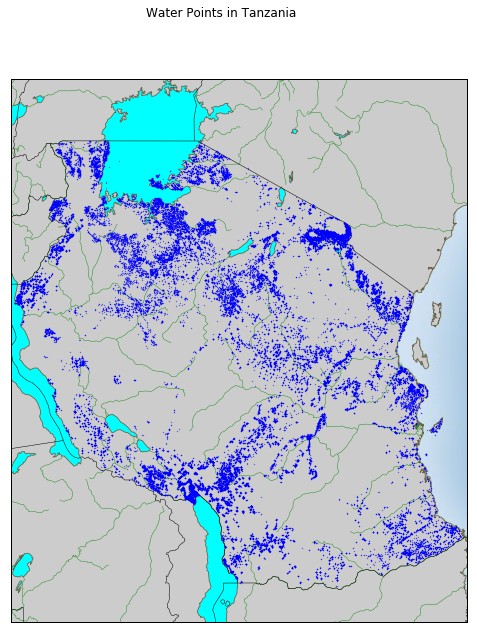

In [652]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize =(20,10))
fig.suptitle("Water Points in Tanzania")
m = Basemap(
    projection='merc', 
    llcrnrlat=lat_min-0.5, 
    urcrnrlat=lat_max+0.5, 
    llcrnrlon=lon_min-0.5, 
    urcrnrlon=lon_max+0.5,
    resolution='i'
)

# Reference: https://matplotlib.org/basemap/users/geography.html
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.8)
m.drawrivers(color='green', linewidth=.4)
m.shadedrelief()
m.drawcountries()
m.fillcontinents(lake_color='aqua')

longitudes = train_features_df['longitude'].tolist()
latitudes = train_features_df['latitude'].tolist()
m.scatter(longitudes, latitudes, s=0.05, zorder=2, latlon=True,  c='blue', cmap="summer")

plt.show()

#### Remove Features Irrelevant
Some fatures likely have little correlation with the business outcome (pump failure prediction) and labels.<br/> 
In particular, we will drop the following features:
* date_recorded & year_recorded - The date and the year the row was entered
* recorded_by - Group entering this row of data
* num_private - No definitions provided

In [653]:
# drop scheme_management feature: too many missing values
train_features_df.drop(['date_recorded', 'num_private', 'id', 'year_recorded', 'recorded_by'], axis =1, inplace = True)
remove_list(categorical_cols,['recorded_by'])
train_features_df.shape

(59400, 37)

#### Remove Catgorical features with a high cardinality (too many levels)

We observe that we have lot of geographic information about the water points and wells, and these might be source of multi-colinerarity:
- Tanzania is divided into thirty-one regions
- Each region is subdivided into districts
- Each districts are sub-divided into divisions and local wards 
- Wards are further subdivided into streets and into villages
- Villages may be further subdivided into hamlets

We will reduce the number of features having high cardinality features and likely to be correlated with other features:
* wpt_name - Name of the waterpoint if there is one <br/>
* subvillage - Geographic location<br/>
* ward - Geographic location<br/>

In [655]:
train_features_df[categorical_cols].nunique().sort_values(ascending=False).head(5)

wpt_name      37399
subvillage    19287
ward           2092
installer      1936
funder         1897
dtype: int64

In [656]:
high_card_cat = ['wpt_name', 'subvillage','ward']
train_features_df.drop(high_card_cat, axis =1, inplace = True)
remove_list(categorical_cols,high_card_cat)
train_features_df.shape

(59400, 34)

In [657]:
train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 34 columns):
amount_tsh               59400 non-null float64
funder                   59400 non-null object
gps_height               59400 non-null int64
installer                59400 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
basin                    59400 non-null object
region                   59400 non-null object
region_code              59400 non-null object
district_code            59400 non-null object
lga                      59400 non-null object
population               59400 non-null int64
public_meeting           59400 non-null bool
scheme_management        59400 non-null object
permit                   59400 non-null bool
construction_year        59400 non-null int64
extraction_type          59400 non-null object
extraction_type_group    59400 non-null object
extraction_type_class    59400 non-null object
ma

In [658]:
train_features_df['status_group'].head()

0        functional
1        functional
2        functional
3    non functional
4        functional
Name: status_group, dtype: object

## Save clean data sets

In [659]:
# Save our cleaned panda dfs in the clean-data repository
train_features_df.to_pickle('clean-data\clean_pump_train_features_df.pkl')

In [660]:
!dir clean-data

 Volume in drive E is DATA
 Volume Serial Number is 6E98-6AE7

 Directory of E:\GitHub\Udacity\machine-learning\projects\capstone-project\clean-data

06/11/2018  11:07 AM    <DIR>          .
06/11/2018  11:07 AM    <DIR>          ..
06/13/2018  01:14 PM        25,569,696 clean_pump_train_features_df.pkl
               1 File(s)     25,569,696 bytes
               2 Dir(s)  1,928,123,465,728 bytes free
